# Spatial Regression for Abundance Data
---
***
Here I show how to extract different taxonomic information at cell level.
Although there exists a method for building the taxonomic tree within a single cell, the process can be computationally intensive because it depends on extracting the total amount of occurrences in each cell. From there, it traverses fromtop to bottom the tree looking for the corresponding nodes.

The approach is usefull when one needs a small number of trees but it'll become increasingly slow if the amount of cells or occurrences increases. 

---

## Extracting specific taxonomic levels en each cells

The method studied here makes use of the relationship type `IS_IN` stored in the knowledge graph.

> Developer's note: *There was a problem with the design of the OGM implementation (py2neo.ogm). The retrieval of linked nodes based on a specific relation does not distinguish different labels. In other words it returns the totality of the data that has the  specific relationship given a node.*

> Patchy solution: 
The solution was to include extra methods for the class Cell `has_[taxas]`. This method/attribute returns a graph selector that points to the corresponding nodes.

> Stable Fix: 
Make relationships as specific as possible (given the data). For example, if instead of using the relation type 
* *IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell) 
change it to:
* *Family_IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell)
Let's get started.
As usual we need to load the necessary modules


In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

## Random selection of cells.

*Note: Data Arquitecture. For storage reasons I couldn't load the complete world bioclimatic layers. Therefore I needed to put a regional subset that comprises only the Mexican Territory. 
For this reason, it is necessary that any approach for selecting subsamples needs to be constrained (filter) by this geometry. 
We can do that with this:

In [42]:
from sketches.models import Country
from mesh.models import MexMesh

Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)

Obtain list of cells within the Mexican Territory.
> The attribute: `mexican_cells.values` is a generator of the Type: QuerySet. We need to cast it to list for loading all the data in memory.


In [105]:
# Get all cell ids
ids = list(mexican_cells.values('pk'))

In [44]:
from traversals.sampling import UniformRandomCellSample

The UniformRandomCellSample is a method for sampling cells in the example below we give as arguments. 

In [45]:
CellNodeClass = Mex4km
list_of_cell_ids = ids
n = len(ids)
selection_of_cells = UniformRandomCellSample(ids,Mex4km,sample_size=200,random_seed=12345,with_replacement=True)

INFO Using custom random seed of: 12345
INFO:biospytial.graph_models:Using custom random seed of: 12345
INFO Compiling Query and asking the Graph Database
INFO:biospytial.graph_models:Compiling Query and asking the Graph Database


The selection should be as follow:
    * Convert to pandas
    * Generate random numbers uniform on that range
    * use iloc to get the id values
    * Use the normal methodology.
    

## Extract richness and Environmental covariates from cells at a given taxonomic level
Options are: Family, Order, Spicies, etc

In [51]:
c = c.first()

In [72]:
c.contained_in._RelatedObjects

[(< Cell-mexico_grid512 id = 43433 >, {})]

In [46]:
from traversals import strategies as st

In [7]:
%time data = st.getEnvironmentAndRichnessFromListOfCells(list_of_cells=selection_of_cells,taxonomic_level_name='Family')

CPU times: user 10.9 s, sys: 276 ms, total: 11.2 s
Wall time: 1min 24s


In [106]:
data.loc[:2]

,n_Family,Longitude,Latitude,Elevation_mean,MaxTemperature_mean,MeanTemperature_mean,MinTemperature_mean,Precipitation_mean,SolarRadiation_mean,Vapor_mean,WindSpeed_mean,geometry
0,4,-113.380563,27.54339,63.222222,30.225231,20.766204,30.317130,7.560185,18867.312500,1.750000,2.263889,POINT (-113.380563416 27.543389801)
1,0,-97.406563,25.68139,3.888889,27.693981,23.069444,27.807870,58.791667,16915.250000,2.212963,4.416667,POINT (-97.406563416 25.681389801)
2,2,-103.629563,22.83939,2353.000000,21.844722,13.783333,21.880556,47.480556,18051.152778,1.000000,3.113889,POINT (-103.629563416 22.839389801)


It takes time because it need to calculate on the fly the summary statistic of each cell. It is using the postgis backend

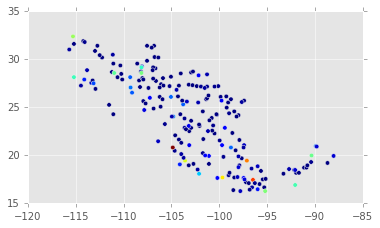

In [9]:
data.plot(column='n_Family')

In [10]:
from external_plugins.spystats.spystats import tools as tl

In [11]:
vg = tl.Variogram(data,response_variable_name='n_Family')

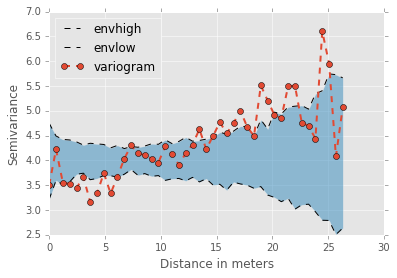

In [12]:
vg.plot(with_envelope=True)

## Let's bring some models

In [13]:
m1 = tl.ExponentialVariogram(nugget=3.5,range_a=15,sill=6.5)
m2 = tl.GaussianVariogram(nugget=3.5,range_a=15,sill=6.5)
m4 = tl.SphericalVariogram(nugget=3.5,range_a=15,sill=6.5)

In [14]:
vg.fitVariogramModel(m2)

< Gaussian Variogram : sill 5.56023920431, range 17.4020551862, nugget 3.53000261509 >

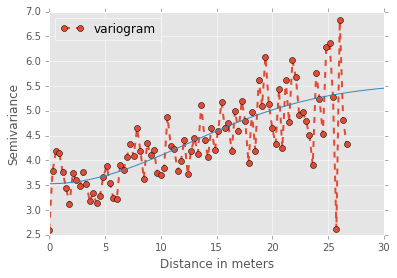

In [15]:
x = np.linspace(0,30,100)

vg.plot(with_envelope=False,n_bins=100)
plt.plot(x,vg.model.f(x))



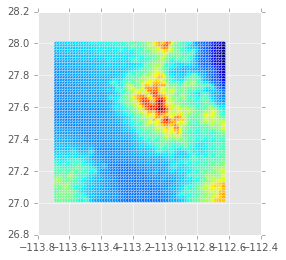

In [16]:
## We will retrieve environmental data from another region using the 'raster_api'
##We will do it like this:
cell = selection_of_cells.first()
## Go up 5 scales
upcell = cell.upperCell.next().upperCell.next().upperCell.next().upperCell.next().upperCell.next()
## Get the raster for this area, example Elevation
elev = upcell.getAssociatedRasterAreaData('Elevation')
## Get a dataframe
data_s = elev.toPandasDataFrame()
## Convert it to geoDataFrame
data_s = tl.toGeoDataFrame(data_s,xcoord_name='Longitude',ycoord_name='Latitude')
## Remove NAs
data_star = data_s.dropna()
## Restablish index to be continuous, this is important
#data_star.reset_index(drop=True,inplace=True)
## Plot it
data_star.plot(column=0)
##

## Small diversion, use the Mexican polygon to obtain covariates for all the region

In [17]:
from raster_api.tools import RasterData

In [88]:
from raster_api.models import ETOPO1, MeanTemperature
elev_map = RasterData(ETOPO1,border=Mexico.geom)

In [19]:
%time elev_map.getRaster()

CPU times: user 68 ms, sys: 28 ms, total: 96 ms
Wall time: 1.21 s


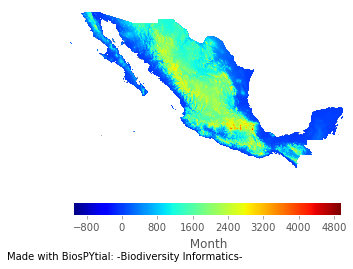

In [20]:
elev_map.display_field()

## Resample from image
Using the new 'resample' method

In [66]:
pixel_size = 0.2
elev_sample = elev_map.rescale(pixel_size)

In [67]:
## Update the rasterdata attribute with the new sample
elev_map.rasterdata = elev_sample

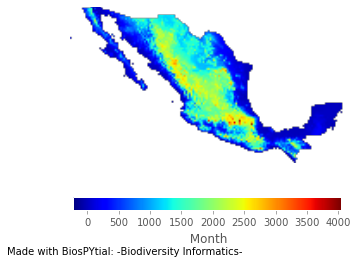

In [68]:
elev_map.display_field(origin='Lower')

In [69]:

small_sample = elev_map.toPandasDataFrame()
elev_data = elev_map.toPandasDataFrame()

In [70]:
small_sample.columns = ['Z','Longitude','Latitude']
small_sample = tl.toGeoDataFrame(small_sample,xcoord_name='Longitude',ycoord_name='Latitude')

#Needed because the index has not been refresheds
small_sample = small_sample.dropna()


In [71]:
#small_sample.reset_index(drop=True,inplace=True)
#small_sample.loc[:10]


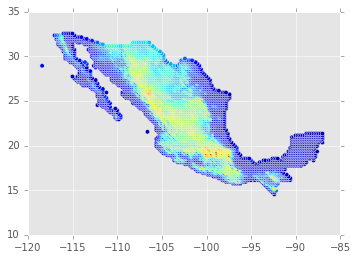

In [72]:
small_sample.plot(column='Z')

## Mean Temperature

In [89]:
mean_temp_map = RasterData(MeanTemperature,border=Mexico.geom)

In [90]:
pixel_size = 0.2
mtemp_sample = mean_temp_map.rescale(pixel_size)

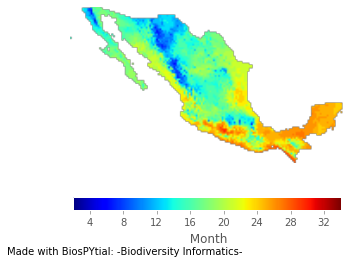

In [93]:
mean_temp_map.rasterdata = mtemp_sample
mean_temp_map.display_field(origin='Lower',band=3)

In [94]:
mean_temp_map.rasterdata.bands[3].data().shape

(91, 159)

In [98]:
elev_sample.bands[0].data().shape

(91, 159)

Tienen el mismo tamaño!!! Gracias a GDAL/Postgis/Biospytial :)

# Bayesian Modelling


In [73]:
import pymc3 as pm
data.columns = [u'n_Family', u'Longitude', u'Latitude', u'Elevation_mean',
       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
       u'WindSpeed_mean', u'geometry']

In [74]:
from statsmodels.genmod.generalized_linear_model import GLM
glmodel = GLM.from_formula('n_Family ~ Elevation_mean',data=data)
res = glmodel.fit()
print(res.summary())


z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])

                 Generalized Linear Model Regression Results                  
Dep. Variable:               n_Family   No. Observations:                  199
Model:                            GLM   Df Residuals:                      197
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                   123.382814666
Method:                          IRLS   Log-Likelihood:                -760.49
Date:                Thu, 15 Mar 2018   Deviance:                       24306.
Time:                        00:23:42   Pearson chi2:                 2.43e+04
No. Iterations:                     4                                         
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          4.1630      1.267      3.287      0.001         1.681     6.645
Elevation_mean     0.0007      0.001    

In [75]:
## cero coef for long lat
z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])
print(coefs)

[ 0.          0.          0.00066554]


In [76]:
## Analysis, GP only one parameter to fit
# The variational method is much beter.
from pymc3.variational.callbacks import CheckParametersConvergence

with pm.Model() as model:
    sigma = 1.0
    #range_a=10.13
    
    
    tau = pm.Uniform('tau',0,5.0)
    #sigma = pm.Flat('sigma')
    #phi = pm.HalfNormal('phi',mu=8,sd=3)
    #phi = pm.Uniform('phi',6,12)
    phi = pm.Uniform('phi',0,15)
    
    Tau = pm.gp.cov.Constant(tau)
    
    cov = sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1]) + Tau
    #K = cov(grid[['Lon','Lat']].values)
    #phiprint = tt.printing.Print('phi')(phi)
    
    
    mf = pm.gp.mean.Linear(coeffs=coefs,intercept=res.params.values[0])

    
    
    
    
    ## The latent function
    gp = pm.gp.Latent(cov_func=cov)
    
    
    
    
    
    ## I don't know why this
    #f = gp.prior("latent_field", X=data[['Longitude','Latitude']].values,reparameterize=False)
    
    f = gp.prior("latent_field", X=data[['Longitude','Latitude','Elevation_mean']].values,reparameterize=False)
    
    
    
    
    
    
    
    #f_print = tt.printing.Print('latent_field')(f)
    
    y_obs = pm.Poisson('y_obs',mu=np.exp(f),observed=data[['n_Family']].values)
    
    #y_obs = pm.MvNormal('y_obs',mu=np.zeros(n*n),cov=K,observed=grid.Z)

    #gp = pm.gp.Latent(cov_func=cov,observed=sample)
    # Use elliptical slice sampling
    #ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K)
    #step = pm.HamiltonianMC()
    #step = pm.Metropolis()
    #%time trace = pm.sample(5000,step)#,tune=0,chains=1)
    ## Variational
    
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
    %time trace = mean_field.sample(draws=5000)

#with model:    
    
    ## For predicting
    #%time f_star = gp.conditional("f_star", data_star.iloc[:,1:3].values)
    #%time f_star = gp.conditional("f_star", small_sample.iloc[:,1:3].values)
    %time f_star = gp.conditional("f_star", small_sample[['Longitude','Latitude','Z']].values)

    ## Full data
    ##%time f_star = gp.conditional("f_star",elev_data.iloc[:,1:3].values)


    
#with model:
    ## sampling predictions posterior predictive checks
    pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=10)

                    


Average Loss = 3.1104e+05: 100%|██████████| 15000/15000 [01:50<00:00, 136.34it/s]

CPU times: user 6min 43s, sys: 33.3 s, total: 7min 17s
Wall time: 1min 53s
CPU times: user 2.3 s, sys: 52 ms, total: 2.35 s
Wall time: 1.21 s
CPU times: user 8.12 s, sys: 1.08 s, total: 9.21 s


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


Wall time: 3.48 s


In [77]:
preds = pd.DataFrame(pred_samples['f_star']).transpose()

In [78]:
preds['mean_sample'] = preds.mean(axis=1)

In [79]:
#preds['idx'] = data_star.index.values
preds['idx'] = small_sample.index.values

In [80]:
elev_data = tl.toGeoDataFrame(elev_data,'Longitude','Latitude')

In [81]:

#test1 = data_s.merge(preds,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
test1 = elev_data.merge(preds,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
## Only the values of small_sample
#test2 = elev_data.merge(preds,how='inner',left_index=True,right_on='idx',suffixes=('_obs','_pred'))

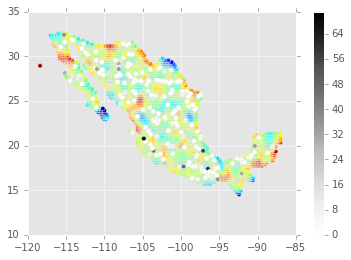

In [104]:
plt.scatter(test1.Longitude,test1.Latitude,c=test1.mean_sample)
plt.scatter(data.Longitude,data.Latitude,c=data.n_Family,cmap=plt.cm.Greys)
plt.colorbar()

In [101]:
data.n_Family

0       4
1       0
2       2
3       9
4       1
5       0
6       0
7       0
8       0
9       0
10      1
11      0
12      0
13      0
14     44
15      0
16      0
17      9
18      0
19      0
20      2
21     60
22      1
23      0
24      0
25      0
26      0
27      0
28      9
29      5
       ..
169     0
170    35
171     5
172    17
173     0
174     2
175     0
176     0
177     3
178     4
179     8
180     1
181     4
182     0
183    33
184     0
185     0
186     1
187     1
188     2
189     2
190     0
191     0
192     0
193     0
194     6
195     0
196     0
197     0
198    16
Name: n_Family, dtype: int64

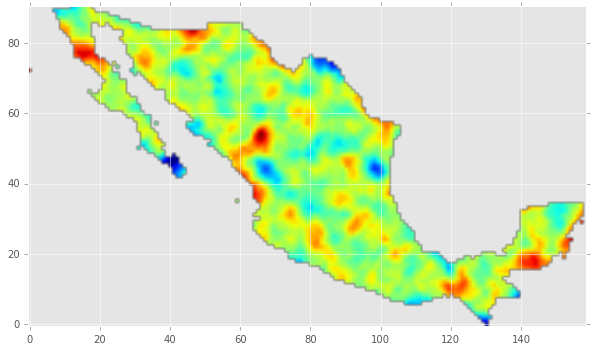

In [86]:
fig, ax = plt.subplots(figsize=(10, 9));
h = elev_map.rasterdata.height
w = elev_map.rasterdata.width
plt.imshow(test1.mean_sample.values.reshape(h,w),origin='lower')
#plt.colorbar()

In [ ]:
#To geotiff


# Convert to a raster format.
 ## Motivation
 It's important for visualization and compatibility with GIS software to generate the results in a standard raster format.
 For achieving this I'll explore *rasterio* package (MapBox, 2016)

In [ ]:
import rasterio as rast

In [ ]:
from rasterio.features import rasterize,guard_transform

In [ ]:
import numpy as np

In [ ]:
geotest1 = tl.toGeoDataFrame(test1,'Longitude','Latitude')
#geotest2 = t1.toGeoDataFrame(test2,'Longitude','Latitude')

In [ ]:
geotest2 = tl.toGeoDataFrame(test2,'Longitude','Latitude')

In [ ]:
shapes = ((geom,val) for geom, val in zip(geotest2.geometry,np.exp(test2.mean_sample.values)))

In [ ]:
shapes = list(shapes)
len(shapes)


In [ ]:
#rastband1 = elev.rasterdata.bands[0].data()

newr = rasterize(shapes,out_shape=(10,10),all_touched=False,fill=np.nan,transform=elev_map.rasterdata.geotransform)

In [ ]:
geotest2

In [ ]:
plt.imshow(newr)

In [ ]:
Z = test2.mean_sample.values.reshape(100,100)
Z1 = np.ma.masked_where(Z == np.nan,Z)

In [ ]:
plt.imshow(np.exp(Z1),cmap=plt.cm.Accent)
plt.colorbar()

In [ ]:
## With pcolormesh
x = np.linspace(0,100,w)
y = np.linspace(0,100,h)
XX,YY = np.meshgrid(x,y)
ZZ = np.exp(Z1)
z_min = np.nanmin(ZZ)
z_max = np.nanmax(ZZ)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9));
plt.pcolor(XX,YY,np.exp(Z1),cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar()

In [ ]:
b = elev.rasterdata.bands[0]

In [ ]:
values = b.data()

In [ ]:
from matplotlib import colors

In [ ]:
# colormap normalizer

fig, ax = plt.subplots(figsize=(10, 9));
plt.pcolor(XX,YY,values,cmap=plt.cm.CMRmap_r,norm = colors.Normalize(vmin=0.0,vmax=1800))
plt.colorbar()